In [43]:
import bnlearn as bn
from sklearn.metrics import f1_score
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
from pgmpy.models import BayesianModel
import pandas as pd



In [44]:
def calculate_f1_score(true_adj_matrix, predicted_adj_matrix):
    # Convert Models to adjacency matrices or any suitable representation
    # true_adj_matrix = true_model['adjmat']
    # predicted_adj_matrix = predicted_model['adjmat']

    # Flatten matrices for F1-score calculation
    true_flat = np.array(true_adj_matrix).flatten()
    pred_flat = np.array(predicted_adj_matrix).flatten()

    # Calculate F1-score
    f1 = f1_score(true_flat, pred_flat, average='micro')

    return f1


In [45]:
true_model = bn.import_DAG('sprinkler')

true_model

[bnlearn] >Import <sprinkler>
[bnlearn] >Check whether CPDs sum up to one.


{'model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x272091e0a90>,
 'adjmat': target     Cloudy  Sprinkler   Rain  Wet_Grass
 source                                        
 Cloudy      False       True   True      False
 Sprinkler   False      False  False       True
 Rain        False      False  False       True
 Wet_Grass   False      False  False      False}

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


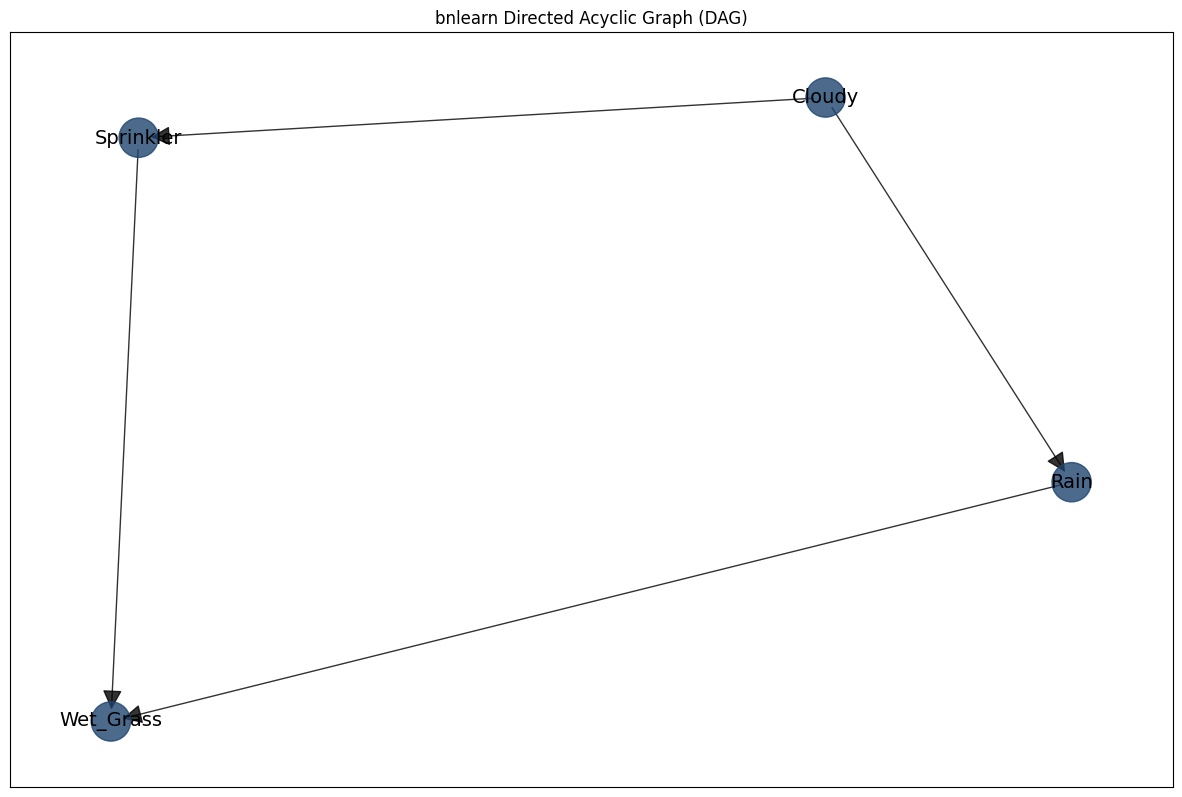

In [46]:
G = bn.plot(true_model)

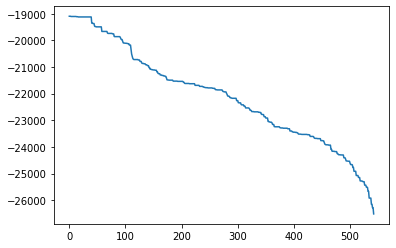

In [47]:
df = bn.sampling(true_model, n=10000)
# Structure learning of sampled dataset
model_learned = bn.structure_learning.fit(df, methodtype='ex', scoretype='bic', verbose = 0, return_all_dags=True)

scores = np.array(model_learned['scores'])

In [49]:
def array_to_dataframe(model, adj_array):
    matrix = model['adjmat'].copy()
    matrix.iloc[:] = adj_array
    return matrix

def model_to_adj(model):
    adj_mat_arrays = [nx.adjacency_matrix(dag).todense() for dag in model['dag']]
    return adj_mat_arrays

def get_score_freq(model):
    n = len(model['scores'])
    freq_scores = {}
    for i in range(n):
        curr_score = model['scores'][i]
        if curr_score not in freq_scores:
            freq_scores[curr_score] = 0
        freq_scores[curr_score] += 1
    return freq_scores 


adj_mat_arrays = model_to_adj(model_learned)

freq_scores = get_score_freq(model_learned)

sorted_freq_scores = dict(sorted(freq_scores.items(), key=lambda item: item[0]))


### All best fit DAGs 

In [50]:
def get_all_best_fits(model, greater_score_better = True):
    all_scores = model['scores']
    best_fit_indices = []
    best_bic = 1e9*(-1)**(greater_score_better)

    for i, score in enumerate(all_scores):
        if score == best_bic:
            best_fit_indices.append(i)
            continue
        if (score < best_bic)^greater_score_better:
            best_bic = score
            best_fit_indices = [i]
        
    
    all_best_fits = {'adjmat': [], 'score': best_bic, 'num_best_fits': len(best_fit_indices)}
    adj_mat_arrays = model_to_adj(model)

    for i in best_fit_indices:
        adj_mat = array_to_dataframe(model, adj_mat_arrays[i])
        all_best_fits['adjmat'].append(adj_mat)

    return all_best_fits

all_best_fits = get_all_best_fits(model_learned)

In [52]:
def plot_from_adj_mat(adj_mat):
    G = nx.DiGraph(adj_mat)

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=10, edge_color='gray', arrowsize=20)

    plt.show()

### f1 scores of Best Fit DAGs

In [55]:
f1_scores = [calculate_f1_score(true_model['adjmat'], all_best_fits['adjmat'][i]) for i in range(all_best_fits['num_best_fits'])]

f1_scores

[0.875, 0.625, 1.0]

### Predicted Model 

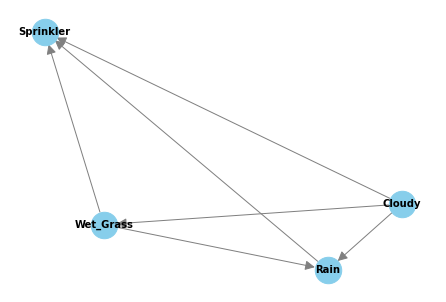

In [56]:
model_learned = bn.structure_learning.fit(df, scoretype='bic', verbose = 0)

plot_from_adj_mat(model_learned['adjmat'])


In [57]:
f1_model_learned = calculate_f1_score(true_model['adjmat'], model_learned['adjmat'])

print(f'F1 Score of the predicted model : {f1_model_learned}')

F1 Score of the predicted model : 0.625
